In [7]:
%run "! DEFAULT PLOT THINGIES.ipynb"
%run "../! DEFAULT PLOT THINGIES.ipynb"

import glob
import pandas as pd
import scipy.io
from hdf_tools.pytables_import_shear import load_measurement
from hdf_tools import getcc

from __future__ import division

ERROR: File `u'! DEFAULT PLOT THINGIES.ipynb.py'` not found.


<IPython.core.display.Javascript object>

`%matplotlib` prevents importing * from pylab and numpy


Current working directory is now c:\users\deen\dropbox\phd rearrangements\thesis\notebooks\sven-trajectories-flip
Populating the interactive namespace from numpy and matplotlib


In [8]:
(
    notP,seed,step_num,
    cc_strained,cc_no,
    gamma_before,gamma_after,
    s_xy_strained_min,s_xy_strained_plus,
    U_strained_min,U_strained_plus,
    rsq,affinersq,
    Lxx,Lxy,Lyx,Lyy,
    ccr0,ccr1,ccr2,ccr3,
    num_cc_changed_r0,num_cc_changed_r1,num_cc_changed_r2,num_cc_changed_r3,
    COMx,COMy,
    prat,
    num01p,num05p,num10p,num15p,num20p,
    num01s,num05s,num10s,num15s,num20s,
    rad_gyr_01p,rad_gyr_05p,rad_gyr_10p,rad_gyr_15p,rad_gyr_20p,
    rad_gyr_01s,rad_gyr_05s,rad_gyr_10s,rad_gyr_15s,rad_gyr_20s,
    rad_hyd_01p,rad_hyd_05p,rad_hyd_10p,rad_hyd_15p,rad_hyd_20p,
    rad_hyd_01s,rad_hyd_05s,rad_hyd_10s,rad_hyd_15s,rad_hyd_20s,
    rad_gr_w,rad_hr_w,
    _,_,_
) = scipy.io.loadmat(r"F:\Leiden Data\Summarized\all_cc_all_data")['all_cc_times_512'].T

pressure = notP.copy()
pressure[notP>0.1] = (notP/1e3)[notP>0.1]

In [9]:
def load_alphalist(alphalist):
    # dan gaan we nu proberen de gekke datafiles in te lezen. We beginnen met alphalist_strain
    import ast

    sven_data = {'alpha': [], 'endstates': []}

    i = 0
    for line in open(alphalist):
        if line.startswith('a'):
            sven_data['alpha'].append(np.float64(line[25:].split(" ", 1)[0]))
            i += 1
        elif line.startswith('{'):
            data = ast.literal_eval(line)
            data["index"] = i
            sven_data['endstates'].append( data)
        else:
            pass
        
    sven_data['alpha'] = np.array(sven_data['alpha'])
    return sven_data

def get_event_alpha(alphalist, event):
    previous = {'index': 0}
    for i in alphalist['endstates']:
        if i['step#'] == event:
            break
        else:
            previous = i
    
    alphas = np.array(alphalist['alpha'][previous['index']:i["index"]])
    return alphas

def get_final_steps(alphas):
    fs = np.concatenate([np.where(np.diff(np.unique(alphas, return_inverse=True)[-1]) != 0)[0], [len(alphas)-1]])
    #fs = fs[fs > len(alphas)/2]
    return fs

def load_relaxation(wholepath, length, p0, p1):
    X = np.loadtxt(wholepath, usecols=[p0,p1])

    if length:
        X = X[-length:]
    
    return X[:,0] - X[:,1]



In [12]:
rearr_tresh_rsq = 1e-11
msk = (pressure == 1e-2) * (seed == 8005) #* (rsq > rearr_tresh_rsq)
print rsq[msk]
print np.sum(rsq[msk] > rearr_tresh_rsq)

rearrs = np.where(rsq[msk] > rearr_tresh_rsq)[0]
print rearrs

rmsk = msk * (rsq > rearr_tresh_rsq)
print step_num[rmsk]

[  9.20090617e-18   4.44896938e-17   4.57846402e-17   1.08247967e-16
   1.14328813e-16   1.31181973e-16   1.36688002e-16   2.77069599e-16
   2.89233175e-16   2.94252783e-16   9.64834556e-08   9.56653130e-16
   1.14394148e-15   1.41024113e-15   1.56265923e-15   1.88989205e-06
   1.93015933e-15   2.05269325e-15   2.23866278e-15   2.57405884e-15
   2.81130414e-15   3.08618588e-15   5.54710698e-02   2.30326900e-15
   2.30865497e-15]
3
[10 15 22]
[ 211.  324.  458.]


In [13]:
path = r"F:\Leiden Data\P010e-1\8005"

alphalist_stress_file = glob.glob(path + "/alphalist_stress_*")[0]
alphalist_stress = load_alphalist(alphalist_stress_file)

alphalist_strain_file = glob.glob(path + "/alphalist_strain_*")[0]
alphalist_strain = load_alphalist(alphalist_strain_file)

def get_event_id(event):
    return int(event.split("_E")[1].split("_")[0])

events = sorted(glob.glob(path + "\*FIRE_stress*.txt"), key=get_event_id)
event_ids = [get_event_id(e) for e in events]

basename = os.path.split(glob.glob(path + "/log*step*.txt")[0])[1].split("log")[1]
comments, packings, log = load_measurement(path, basename)
packings = packings.to_records()

basepack = packings[0]
alpha0 = packings[0]['alpha']

497


\includegraphics{notebooks/sven-trajectories-flip/trajectory.pdf}


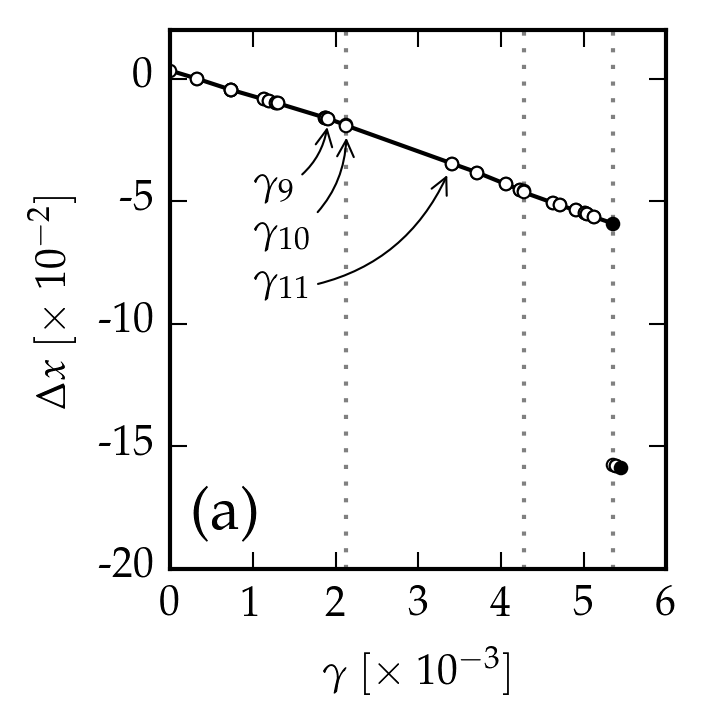

In [14]:
halffig()

#plt.subplot(1,2,1)

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = X-x0
    
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if i in rearrs:
        plt.axvline(befores['gamma'][-1], ls=":", color='gray')

    if len(gamma) > 0:
        plt.plot(gamma, X, "k")
        plt.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
        plt.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]


plt.annotate(
    r"$\gamma_{9}$",
    (strains[9], Xs[9]),
    (1e-3,-5e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0),
)

plt.annotate(
    r"$\gamma_{10}$",
    (strains[10], Xs[10]),
    (1e-3,-7e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
)

plt.annotate(
    r"$\gamma_{11}$",
    (strains[11], Xs[11]),
    (1e-3,-9e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
)

plt.xlabel(r"$\gamma~[\times~10^{-3}]$")
plt.ylabel(r"$\Delta x~[\times~10^{-2}]$")

yt = np.arange(-0.2,0.01,0.05)
plt.yticks(yt, [int(np.round(y * 1e2,0)) for y in yt])

xt = np.arange(0, 0.0061, 0.001)
plt.xticks(xt, [int(x * 1e3) for x in xt])

subplotlabel('(a)', loc='lower left')
plt.savefig('trajectory.pdf')

\includegraphics{notebooks/sven-trajectories-flip/trajectory-zoom.pdf}


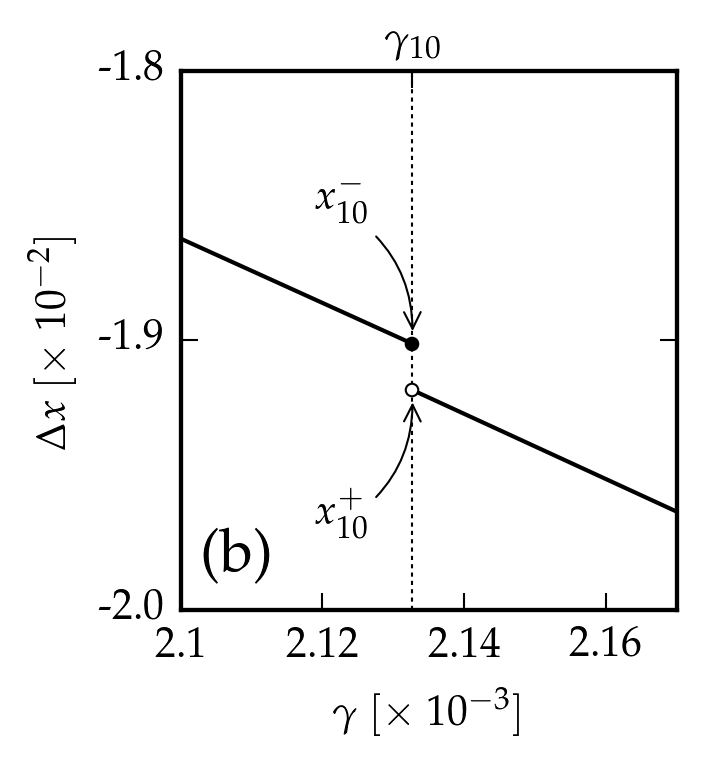

In [15]:
halffig()

pa = 0; pb = 1
x0 = None

previous = None

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #plt.axvline(befores['gamma'][-1], color='gray', lw=0.1)
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)
        
    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = X-x0
    
    if len(gamma) > 0:
        plt.plot(gamma, X, "k")
        plt.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
        if False and 150 < afters[0]['step#'] < 250:
            plt.text(gamma[0], X[0], str(afters[0]['step#']))
            print gamma[0], str(afters[0]['step#'])
        plt.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]
    
    if i == 10:
        ten_X_before = X[-1]
    if i == 11:
        ten_gamma = gamma[0]
        ten_X_after = X[0]
    
plt.axis(xmin=2.1e-3,xmax=2.17e-3,ymin=-0.02,ymax=-0.018)

plt.xlabel(r"$\gamma~[\times~10^{-3}]$")
plt.ylabel(r"$\Delta x~[\times~10^{-2}]$")

yt = np.arange(-0.02,-0.018,0.001)
plt.yticks(yt, [np.round(y * 1e2,3) for y in yt])

xt = np.arange(2.1e-3, 2.17e-3, 0.02e-3)
plt.xticks(xt, [np.round(x * 1e3,2) for x in xt])

plt.annotate(
    r"$x_{10}^-$",
    (ten_gamma, ten_X_before),
    (ten_gamma-0.01e-3,ten_X_before+0.05e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
    va='center', ha='center'
)

plt.annotate(
    r"$x_{10}^+$",
    (ten_gamma, ten_X_after),
    (ten_gamma-0.01e-3,ten_X_after-0.05e-2),
    arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.3",
                   linewidth=0.5,
                   shrinkA=0, shrinkB=3),
    va='center', ha='center'
)

plt.axvline(ten_gamma, dashes=(1,1), zorder=-3, color='black', lw=0.5)

ax = plt.axis()
plt.twiny()
plt.axis(ax)
plt.xticks([ten_gamma], [r"$\gamma_{10}$"])
plt.gca().xaxis.set_tick_params(pad=0)

subplotlabel('(b)', loc='lower left')
plt.savefig('trajectory-zoom.pdf')

\includegraphics{notebooks/sven-trajectories-flip/strain-reversal.pdf}


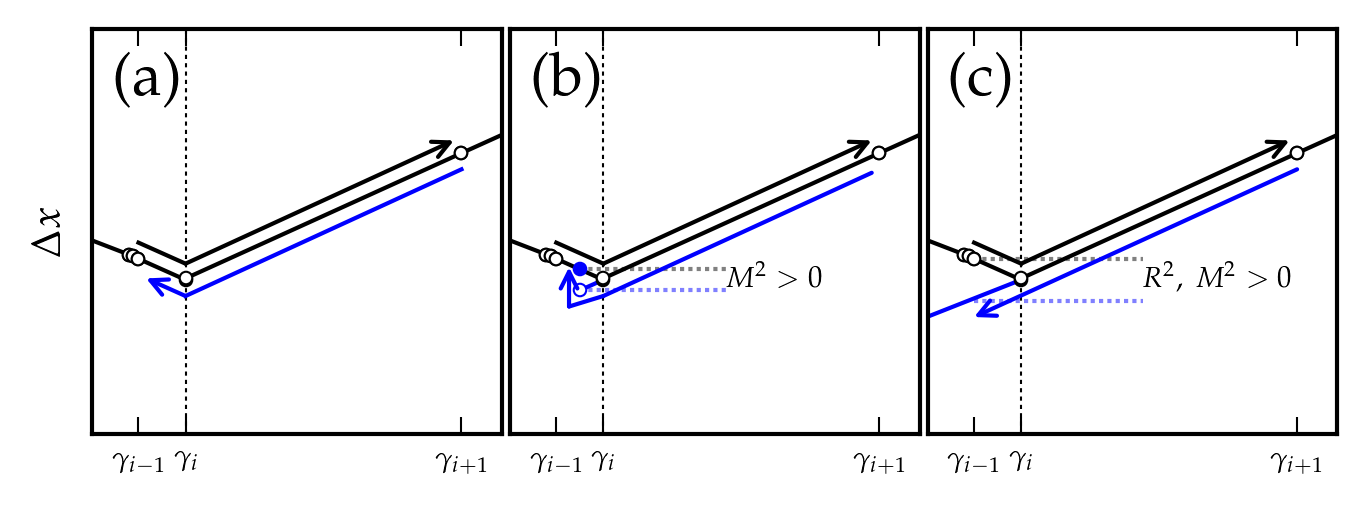

In [47]:
flipX = 0.019012787670096287


fullfig(hf=0.75)

ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

plt.subplots_adjust(wspace=0.02)

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = -(X-x0)
    
    X[X<flipX] = 2*flipX - X[X<flipX]
        
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if len(gamma) > 0:
        for ax in [ax1,ax2,ax3]:
            ax.plot(gamma, X, "k")
            ax.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
            ax.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]

ax1.set_ylabel(r"$\Delta x$")

for ax in [ax1,ax2,ax3]:
#    ax.set_xlabel(r"$\gamma$")
    ax.axis(xmin=1.7e-3, xmax=3.6e-3, ymin=0.00, ymax=0.05)

    ax.set_yticks([])
    ax.set_xticks([strains[9], strains[10], strains[11]])
    ax.set_xticklabels([r"$\gamma_{i-1}$", r"$\gamma_{i}$", r"$\gamma_{i+1}$"], fontsize='x-small')

    ax.plot(
        [strains[9], strains[10]],
        [Xs[9]+2e-3, Xs[10]+2e-3],
        color=fwc
    )
    ax.annotate(
        "",
        (strains[11], Xs[11]+2e-3),
        (strains[10], Xs[10]+2e-3),
        arrowprops=dict(arrowstyle="->", color=fwc, shrinkA=0)
    )

ax1.plot(
    [strains[11], strains[10]],
    [Xs[11]-2e-3, Xs[10]-2e-3],
    color=bwc
)
ax1.annotate(
    "",
    (strains[10], Xs[10]-2e-3),
    (strains[9], Xs[9]-2e-3),
    arrowprops=dict(arrowstyle="<-", color=bwc,shrinkB=0)
)


yv2 = 2*flipX-0.5*(Xs[9]+Xs[10])

ax2.plot(
    [strains[10], (strains[9] + strains[10])/2], # (strains[9] + strains[10])/2],
    [Xs[10], yv2], #, (Xs[9] + Xs[10])/2],
    "b",
    zorder=-3
)

ax2.plot(
    (strains[9] + strains[10])/2,
    yv2,
    "o",
    color="white",    mec=bwc,    ms=3,
)

ax2.plot(
    (strains[9] + strains[10])/2,
    (Xs[9] + Xs[10])/2,
    "o",
    color="blue",    mec=bwc,    ms=3,
)

ax2.annotate(
    "",
    (strains[10], Xs[10]-2e-3),
    (strains[11], Xs[11]-2e-3),
    arrowprops=dict(arrowstyle="-", shrinkB=0, color=bwc)
)


ax2.annotate(
    "",
    ((strains[9] + strains[10])/2-5e-5, yv2-2e-3),
    (strains[10], Xs[10]-2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=bwc)
)

ax2.annotate(
    "",
    ((strains[9] + strains[10])/2-5e-5, Xs[9]),
    ((strains[9] + strains[10])/2-5e-5, yv2-2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, color=bwc)
)

xv = (strains[9] + strains[10])/2
yv = (Xs[9] + Xs[10])/2

ax2.plot([xv, 2.7e-3], [yv, yv], color='gray', zorder=-5, dashes=(1,1))
ax2.plot([xv, 2.7e-3], [yv2, yv2], color=(0.5,0.5,1), zorder=-5,dashes=(1,1))
ax2.text(2.7e-3, 0.5*(yv+yv2), r"$M^2>0$", ha='left', va='center', fontsize='x-small')

##### C

ax3.plot(
    [strains[10], strains[0]],
    [Xs[10], 2*flipX-Xs[0]],
    "b",
    zorder=-3,
)

Xs9old = 2*flipX-Xs[9]

ax3.annotate(
    "",
    (strains[9], Xs9old-2e-3),
    (strains[11], Xs[11]-2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=bwc)
)

ax3.plot([strains[9], 2.7e-3], [Xs[9], Xs[9]], color='gray', zorder=-5, dashes=(1,1))
ax3.plot([strains[9], 2.7e-3], [Xs9old, Xs9old], color=(0.5,0.5,1), zorder=-5, dashes=(1,1))
ax3.text(2.7e-3, 0.5*(Xs[9] + Xs9old), r"$R^2,~M^2>0$", ha='left', va='center', fontsize='x-small')

ax1.axvline(strains[10], lw=0.5, dashes=(1,1), color='black', zorder=-3)
ax2.axvline(strains[10], lw=0.5, dashes=(1,1), color='black', zorder=-3)
ax3.axvline(strains[10], lw=0.5, dashes=(1,1), color='black', zorder=-3)
    
subplotlabel('(a)', ax=ax1)
subplotlabel('(b)', ax=ax2)
subplotlabel('(c)', ax=ax3)

savefig('strain-reversal.pdf')

\includegraphics{notebooks/sven-trajectories-flip/stress-reversal.pdf}


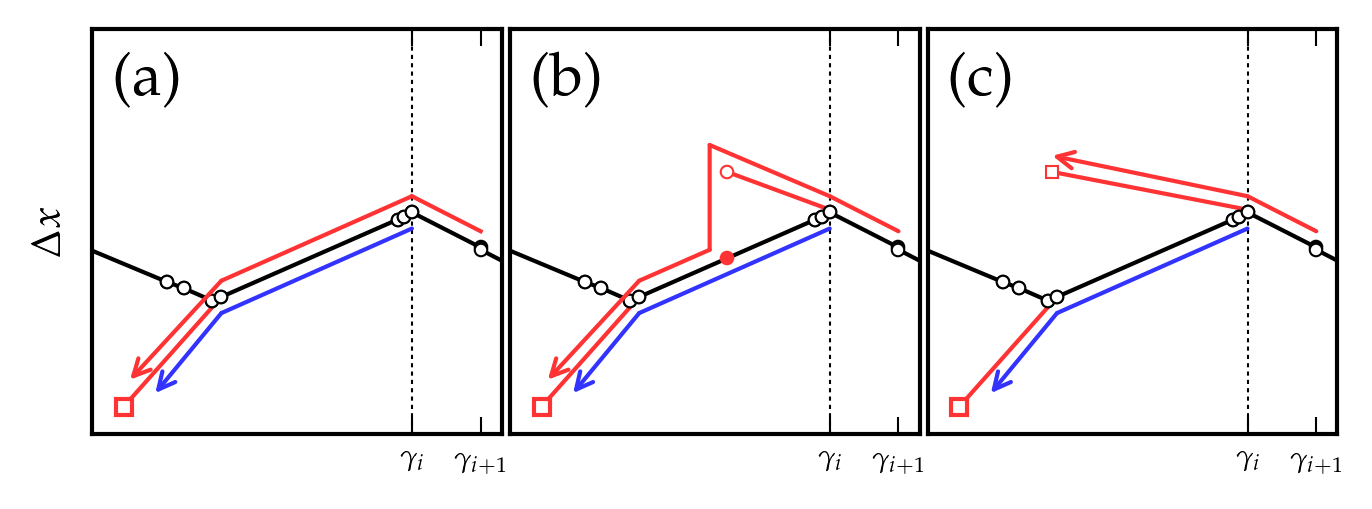

In [56]:



fullfig(hf=0.75)

ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

plt.subplots_adjust(wspace=0.02)

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = -(X-x0)
    
    flipX1 = 0.009864163701763573   # Xs[5]
    X[X<flipX1] = 2*flipX1 - X[X<flipX1]
    
    flipX2 = 0.01641277491337334  # Xs[9]
    X[X>flipX2] = 2*flipX2 - X[X>flipX2]
    
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if len(gamma) > 0:
        for ax in [ax1,ax2,ax3]:
            ax.plot(gamma, X, "k")
            ax.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
            ax.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]


ax1.set_ylabel(r"$\Delta x$")

for ax in [ax1,ax2,ax3]:
#    ax.set_xlabel(r"$\gamma$")
    ax.axis(xmin=0.9e-3, xmax=2.2e-3, ymin=0.00, ymax=0.03)

    ax.set_yticks([])
    ax.set_xticks([strains[9], strains[10]])
    ax.set_xticklabels([r"$\gamma_{i}$", r"$\gamma_{i+1}$"], fontsize='x-small')

    ax.plot(
        [strains[6], 1e-3],
        [Xs[6], 2e-3],
        color=arc,
        zorder=-3,
    )
    
    ax.plot(
        1e-3, 2e-3,
        's',
        color='white',
        mec=arc,
        ms=4,
        mew=1,
    )

    ax.annotate(
        "",
        (strains[6], Xs[6]-1.2e-3),
        (strains[9], Xs[9]-1.2e-3),
        arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=brc)
    )

    ax.annotate(
        "",
        (1.1e-3, 3e-3),
        (strains[6], Xs[6]-1.2e-3),
        arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=brc)
    )

    
ax1.annotate(
    "",
    (strains[6], Xs[6]+1.2e-3),
    (strains[9], Xs[9] + 1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)
ax1.plot([strains[9], strains[10]],
         [Xs[9]+1.2e-3, Xs[10]+1.2e-3],
        color=arc)

ax1.annotate(
    "",
    (1.02e-3, 4e-3),
    (strains[6], Xs[6]+1.2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=arc)
)

ax2.plot(
    [strains[9], 0.5*(strains[6] + strains[7])],
    [Xs[9]+2e-4, Xs[9]+3e-3],
    color=arc,
    zorder=-3
)

ax2.plot(
    0.5*(strains[6] + strains[7]),
    Xs[9]+3e-3,
    "o",
    mec=arc,
    color='white',
    ms=3
)

ax2.plot(
    0.5*(strains[6] + strains[7]),
    0.5*(Xs[6] + Xs[7]),
    "o",
    mec=arc,
    color=arc,
    ms=3
)

ax2.annotate(
    "",
    (strains[9], Xs[9] + 1.2e-3),
    (0.6*(strains[6]) + 0.4*(strains[7]), Xs[9]+5e-3 ),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (0.6*(strains[6]) + 0.4*(strains[7]), Xs[9]+5e-3 ),
    (0.6*(strains[6]) + 0.4*(strains[7]), 0.6*(Xs[6]) + (0.4*Xs[7]) +1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (strains[6], Xs[6]+1.2e-3),
    (0.6*(strains[6]) + 0.4*(strains[7]), 0.6*(Xs[6]) + (0.4*Xs[7]) +1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (1.02e-3, 4e-3),
    (strains[6], Xs[6]+1.2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (strains[9], Xs[9] + 1.2e-3),
    (strains[10], Xs[10] + 1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax3.plot(
    [strains[9], 0.5*(strains[5] + strains[6])],
    [Xs[9]+2e-4, Xs[9]+3e-3],
    color=arc,
    zorder=-3
)

ax3.plot(
    0.5*(strains[5] + strains[6]),
    Xs[9]+3e-3,
    "s",
    mec=arc,
    color='white',
    ms=3
)

ax3.annotate(
    "",
    (0.5*(strains[5] + strains[6]), Xs[9]+3e-3+1.2e-3 ),
    (strains[9], Xs[9] + 1.2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=arc)
)
    
ax3.annotate(
    "",
    (strains[9], Xs[9] + 1.2e-3),
    (strains[10], Xs[10] + 1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)
    
ax1.axvline(strains[9], lw=0.5, dashes=(1,1), color='black', zorder=-3)
ax2.axvline(strains[9], lw=0.5, dashes=(1,1), color='black', zorder=-3)
ax3.axvline(strains[9], lw=0.5, dashes=(1,1), color='black', zorder=-3)
    
subplotlabel('(a)', ax=ax1)
subplotlabel('(b)', ax=ax2)
subplotlabel('(c)', ax=ax3)

savefig('stress-reversal.pdf')

\includegraphics{notebooks/sven-trajectories-flip/negative-stress-example.pdf}


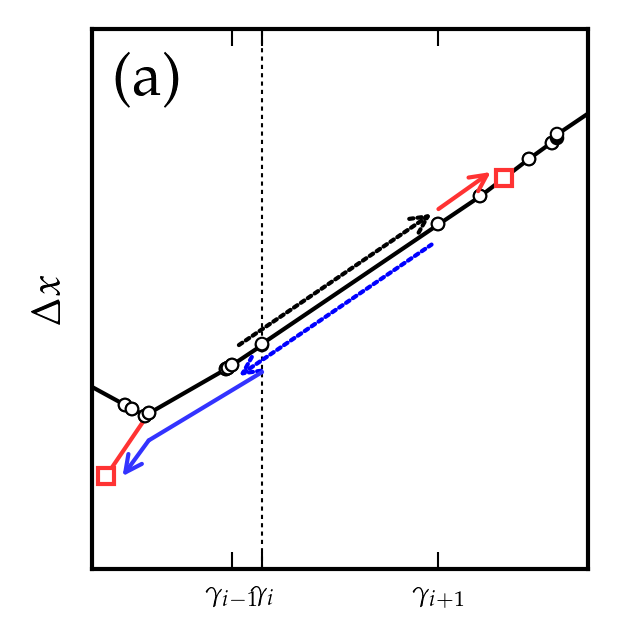

In [72]:
f = halffig()
ax = ax1 = plt.gca()

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = -(X-x0)
    
    flipX1 = 0.009864163701763573   # Xs[5]
    X[X<flipX1] = 2*flipX1 - X[X<flipX1]
    
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if len(gamma) > 0:
            ax.plot(gamma, X, "k")
            ax.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
            ax.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]


ax1.set_ylabel(r"$\Delta x$")

ax.set_yticks([])
ax.set_xticks([strains[9], strains[10], strains[11]])
ax.set_xticklabels([r"$\gamma_{i-1}$", r"$\gamma_{i}$", r"$\gamma_{i+1}$"], fontsize='x-small')

ax.annotate(
    "",
    (strains[11], Xs[11]+2e-3),
    (strains[9], Xs[9]+2e-3),
    arrowprops=dict(arrowstyle="->", linestyle=(0,(1,1)), color=fwc)
)

ax1.annotate(
    "",
    (strains[11], Xs[11]-2e-3),
    (strains[9], Xs[9]-2e-3),
    arrowprops=dict(arrowstyle="<-", color=bwc, linestyle=(0,(1,1))),
)

# STRESS CURVES
ax.plot(
    [strains[6], 1e-3],
    [Xs[6], 2e-3],
    color=arc,
    zorder=-3,
)

ax.plot(
    1e-3, 2e-3,
    's',
    color='white',
    mec=arc,
    ms=4,
    mew=1,
)

ax.annotate(
    "",
    (strains[6], Xs[6]-3.5e-3),
    (strains[10], Xs[10]-3.5e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=brc)
)

ax.annotate(
    "",
    (1.12e-3, 2e-3),
    (strains[6], Xs[6]-3.5e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=brc)
)

ax1.annotate(
    "",
    (0.5*(strains[12]+strains[13]), 0.5*(Xs[12]+Xs[13]) + 2e-3),
    (strains[11], Xs[11] + 2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=4, color=arc)
)

ax.plot(
    0.5*(strains[12]+strains[13]), 0.5*(Xs[12]+Xs[13]),
    's',
    color='white',
    mec=arc,
    ms=4,
    mew=1,
)

ax1.axvline(strains[10], lw=0.5, dashes=(1,1), color='black', zorder=-3)


subplotlabel('(a)', ax=ax1)

ax.axis(xmin=0.9e-3, xmax=4.5e-3, ymin=-0.01, ymax=0.06)
#ax.axis(xmin=1.7e-3, xmax=3.6e-3, ymin=0.00, ymax=0.05)
savefig('negative-stress-example.pdf')

\includegraphics{notebooks/sven-trajectories-flip/loop-strain-irrev-a.pdf}


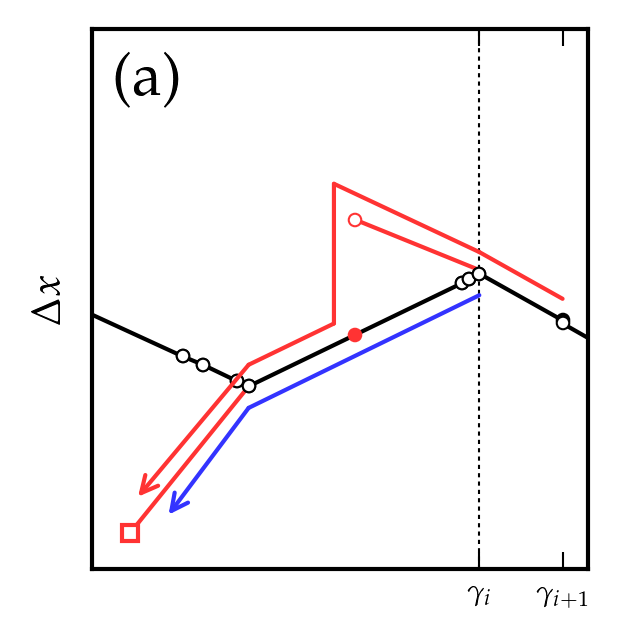

In [77]:
f = halffig()
ax = ax2 = plt.gca()

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = -(X-x0)
    
    flipX1 = 0.010141848730516045   # Xs[6]
    X[X<flipX1] = 2*flipX1 - X[X<flipX1]
    
    flipX2 = 0.01641277491337334  # Xs[9]
    X[X>flipX2] = 2*flipX2 - X[X>flipX2]
    
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if len(gamma) > 0:
            ax.plot(gamma, X, "k")
            ax.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
            ax.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]


ax2.set_ylabel(r"$\Delta x$")

ax.axis(xmin=0.9e-3, xmax=2.2e-3, ymin=0.00, ymax=0.03)

ax.set_yticks([])
ax.set_xticks([strains[9], strains[10]])
ax.set_xticklabels([r"$\gamma_{i}$", r"$\gamma_{i+1}$"], fontsize='x-small')

ax.plot(
    [strains[6], 1e-3],
    [Xs[6], 2e-3],
    color=arc,
    zorder=-3,
)

ax.plot(
    1e-3, 2e-3,
    's',
    color='white',
    mec=arc,
    ms=4,
    mew=1,
)

ax.annotate(
    "",
    (strains[6], Xs[6]-1.2e-3),
    (strains[9], Xs[9]-1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=brc)
)

ax.annotate(
    "",
    (1.1e-3, 3e-3),
    (strains[6], Xs[6]-1.2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=brc)
)

ax2.plot(
    [strains[9], 0.5*(strains[6] + strains[7])],
    [Xs[9]+2e-4, Xs[9]+3e-3],
    color=arc,
    zorder=-3
)

ax2.plot(
    0.5*(strains[6] + strains[7]),
    Xs[9]+3e-3,
    "o",
    mec=arc,
    color='white',
    ms=3
)

ax2.plot(
    0.5*(strains[6] + strains[7]),
    0.5*(Xs[6] + Xs[7]),
    "o",
    mec=arc,
    color=arc,
    ms=3
)

ax2.annotate(
    "",
    (strains[9], Xs[9] + 1.2e-3),
    (0.6*(strains[6]) + 0.4*(strains[7]), Xs[9]+5e-3 ),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (0.6*(strains[6]) + 0.4*(strains[7]), Xs[9]+5e-3 ),
    (0.6*(strains[6]) + 0.4*(strains[7]), 0.6*(Xs[6]) + (0.4*Xs[7]) +1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (strains[6], Xs[6]+1.2e-3),
    (0.6*(strains[6]) + 0.4*(strains[7]), 0.6*(Xs[6]) + (0.4*Xs[7]) +1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (1.02e-3, 4e-3),
    (strains[6], Xs[6]+1.2e-3),
    arrowprops=dict(arrowstyle="->", shrinkA=0, shrinkB=0, color=arc)
)

ax2.annotate(
    "",
    (strains[9], Xs[9] + 1.2e-3),
    (strains[10], Xs[10] + 1.2e-3),
    arrowprops=dict(arrowstyle="-", shrinkA=0, shrinkB=0, color=arc)
)

ax2.axvline(strains[9], lw=0.5, dashes=(1,1), color='black', zorder=-3)
subplotlabel('(a)')
savefig('loop-strain-irrev-a.pdf')

\includegraphics{notebooks/sven-trajectories-flip/loop-strain-irrev-b.pdf}


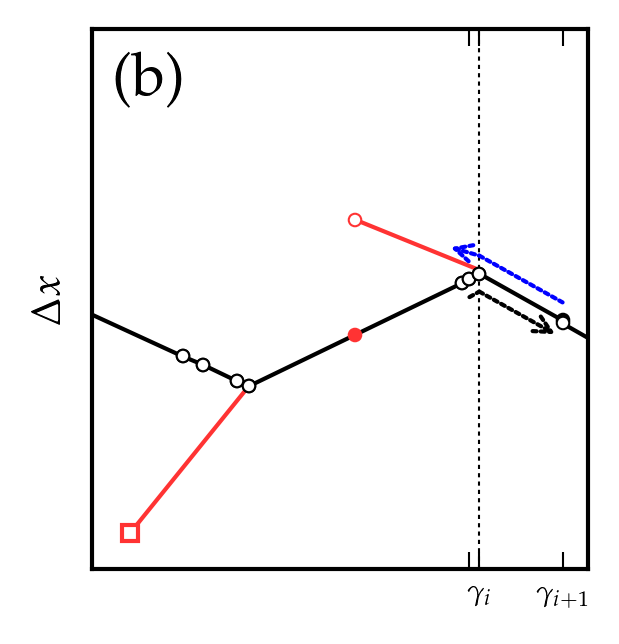

In [82]:
f = halffig()
ax = ax2 = plt.gca()

pa = 0; pb = 1
x0 = None

previous = None

strains = []
Xs = []

for i,(befores,afters) in enumerate(getcc.get_multi_ccs(None, packings, full=True)):
    #
    
    X = [s['particles']['x'] for s in befores]
    X = np.array([s[pa] - s[pb] for s in X])
    
    if x0 is None:
        x0 = np.amin(X)

    gamma = befores['gamma']
    
    if previous is not None:
        pX = previous['particles']['x']
        pX = pX[pa] - pX[pb]
        X = np.concatenate([[pX], X])
        gamma = np.concatenate([[previous['gamma']], gamma])
        
    X = -(X-x0)
    
    flipX1 = 0.010141848730516045   # Xs[6]
    X[X<flipX1] = 2*flipX1 - X[X<flipX1]
    
    flipX2 = 0.01641277491337334  # Xs[9]
    X[X>flipX2] = 2*flipX2 - X[X>flipX2]
    
    strains.append(gamma[-1])
    Xs.append(X[-1])
    
    if len(gamma) > 0:
            ax.plot(gamma, X, "k")
            ax.plot(gamma[0], X[0], "o", mec='k', color='white', ms=3)
            ax.plot(gamma[-1], X[-1], "ko", ms=3)
    
    previous = afters[0]


ax2.set_ylabel(r"$\Delta x$")

ax.set_yticks([])
ax.set_xticks([strains[8], strains[9], strains[10]])
ax.set_xticklabels([r"", r"$\gamma_{i}$", r"$\gamma_{i+1}$"], fontsize='x-small')

ax.plot(
    [strains[6], 1e-3],
    [Xs[6], 2e-3],
    color=arc,
    zorder=-3,
)

ax.plot(
    1e-3, 2e-3,
    's',
    color='white',
    mec=arc,
    ms=4,
    mew=1,
)

ax2.plot(
    [strains[9], 0.5*(strains[6] + strains[7])],
    [Xs[9]+2e-4, Xs[9]+3e-3],
    color=arc,
    zorder=-3
)

ax2.plot(
    0.5*(strains[6] + strains[7]),
    Xs[9]+3e-3,
    "o",
    mec=arc,
    color='white',
    ms=3
)

ax2.plot(
    0.5*(strains[6] + strains[7]),
    0.5*(Xs[6] + Xs[7]),
    "o",
    mec=arc,
    color=arc,
    ms=3
)

ax.annotate(
    "",
    (strains[10], Xs[10]-1e-3),
    (strains[9], Xs[9]-1e-3),
    arrowprops=dict(arrowstyle="->", linestyle=(0,(1,1)), color=fwc, shrinkA=0)
)

ax.annotate(
    "",
    (strains[9], Xs[9]-1e-3),
    (strains[8], Xs[8]-1e-3),
    arrowprops=dict(arrowstyle="-", linestyle=(0,(1,1)), color=fwc, shrinkB=0, shrinkA=0)
)

ax.annotate(
    "",
    (strains[10], Xs[10]+1e-3),
    (strains[9], Xs[9]+1e-3),
    arrowprops=dict(arrowstyle="-", color=bwc, linestyle=(0,(1,1)), shrinkA=0, shrinkB=0),
)

ax.annotate(
    "",
    (strains[9], Xs[9]+1e-3),
    (strains[7]-3e-5, Xs[7]+2e-3),
    arrowprops=dict(arrowstyle="<-", color=bwc, linestyle=(0,(1,1)), shrinkA=0, shrinkB=0),
)

ax2.axvline(strains[9], lw=0.5, dashes=(1,1), color='black', zorder=-3)
subplotlabel('(b)')
ax.axis(xmin=0.9e-3, xmax=2.2e-3, ymin=0.00, ymax=0.03)
savefig('loop-strain-irrev-b.pdf')